In [1]:
# load required libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
library(Seurat)
library(harmony)
library(ggplot2)
library(ggpubr)
library(dplyr)
library(Matrix)
library(Hmisc)
library(RColorBrewer)
library(ggrepel)
library(reshape2)
library(ggpubr)
library(gtools)
})
set.seed(123)

In [2]:
# load samples with TE
samples <- list.files('./matrix/', pattern = "TE")
samples

[1] "Aorta-4wk-658_TE.csv" "Aorta-5wk-555_TE.csv" "Aorta-5wk-575_TE.csv"

In [3]:
# create seurat object list
sample_list <- lapply(samples, function(sample){
    count_matrix <- read.csv(paste("./matrix", sample, sep = "/"), row.names = 1, check.names = F)
    sample <- CreateSeuratObject(count_matrix, project = unlist(strsplit(sample, split = "_"))[1])
})
sample_list

[[1]]
An object of class Seurat 
1197 features across 10000 samples within 1 assay 
Active assay: RNA (1197 features, 0 variable features)

[[2]]
An object of class Seurat 
1197 features across 4862 samples within 1 assay 
Active assay: RNA (1197 features, 0 variable features)

[[3]]
An object of class Seurat 
1197 features across 5468 samples within 1 assay 
Active assay: RNA (1197 features, 0 variable features)


In [4]:
# merge samples
sample_TE <- merge(sample_list[[1]], sample_list[2:3])
sample_TE
saveRDS(sample_TE, "sample_human_TE_raw.rds")

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


An object of class Seurat 
1197 features across 20330 samples within 1 assay 
Active assay: RNA (1197 features, 0 variable features)

In [5]:
# extract the annotated EHT cells
sample_gene <- readRDS("../1_EHT_RNA_Preprocessing/sample_human_annotated.rds")
sample_TE <- subset(sample_TE, cells = intersect(colnames(sample_TE), colnames(sample_gene)))
sample_TE

An object of class Seurat 
1197 features across 4158 samples within 1 assay 
Active assay: RNA (1197 features, 0 variable features)

In [6]:
# integrate the EHT and TE sample
count_matrix_all <- rbind(sample_gene@assays$RNA@counts, sample_TE@assays$RNA@counts)
sample <- CreateSeuratObject(count_matrix_all, meta.data = sample_gene@meta.data)
sample@misc$celltype_marker_genes <- sample_gene@misc$celltype_marker_genes
sample

An object of class Seurat 
37798 features across 4158 samples within 1 assay 
Active assay: RNA (37798 features, 0 variable features)

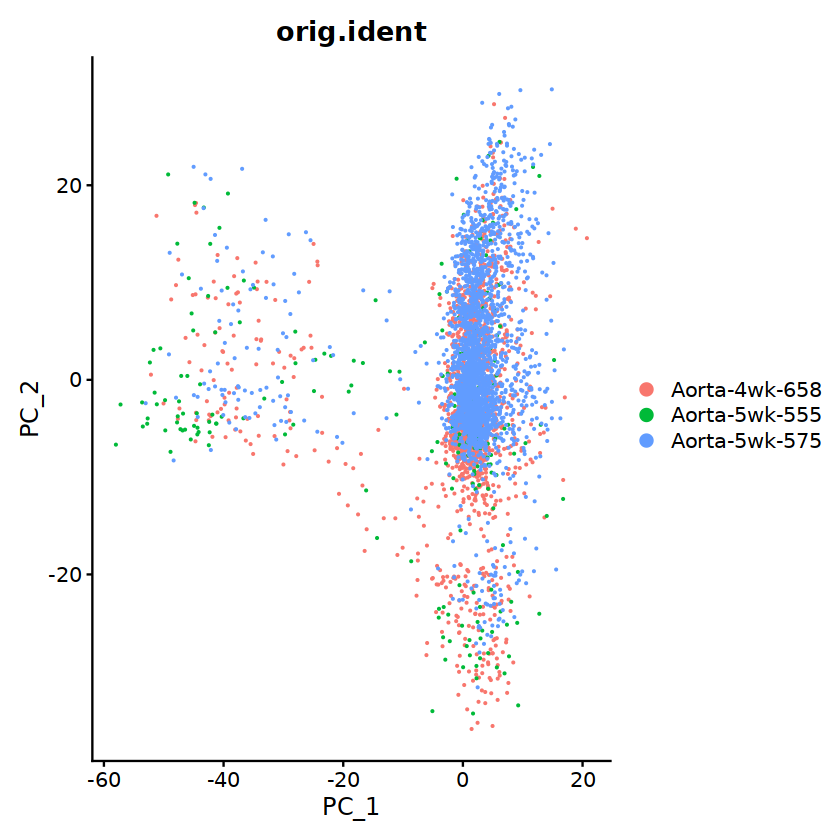

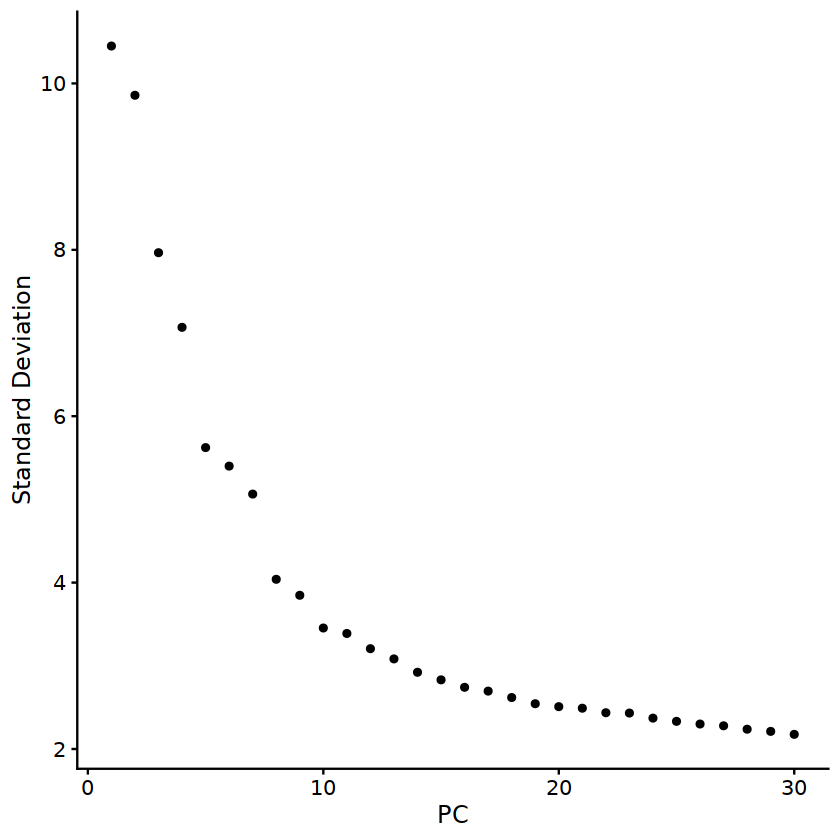

In [7]:
# normalization and pca
sample <- SCTransform(sample, return.only.var.genes = F, method = "glmGamPoi", do.scale = T, verbose = FALSE)
sample <- RunPCA(sample, verbose = FALSE)
DimPlot(sample, reduction = "pca", pt.size = 0.1, group.by = "orig.ident")
ElbowPlot(sample, ndims = 30)

In [8]:
# dimension reduction
pca_dims <- 1:25
sample <- RunTSNE(sample, dims = pca_dims, verbose = FALSE)
sample <- RunUMAP(sample, dims = pca_dims, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


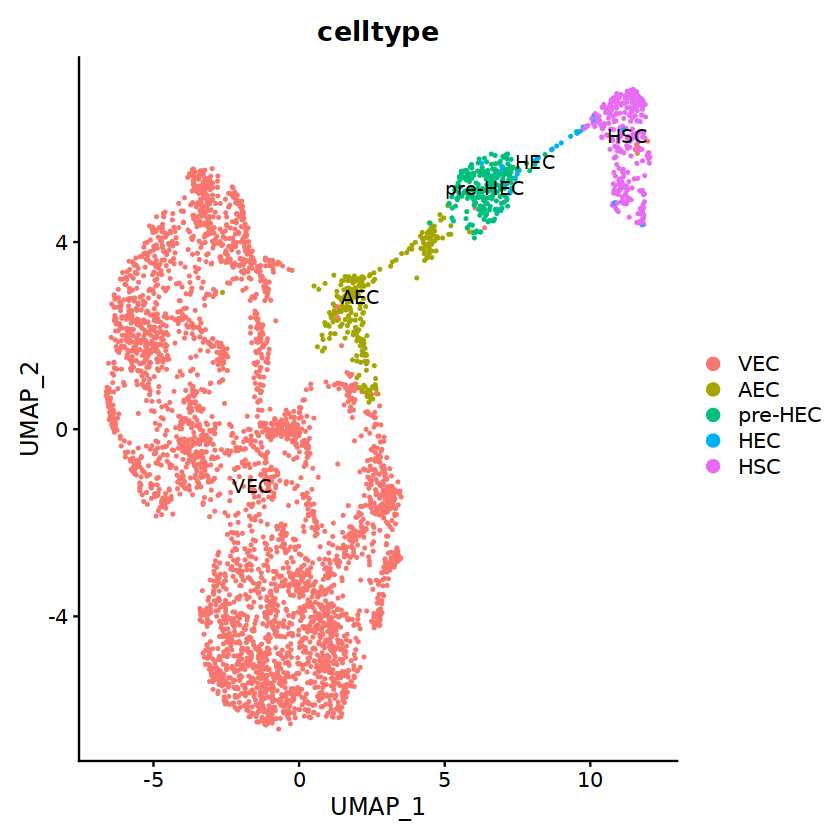

In [9]:
# transfer the cell embeddings
sample@reductions$tsne@cell.embeddings <- sample_gene@reductions$tsne@cell.embeddings
sample@reductions$umap@cell.embeddings <- sample_gene@reductions$umap@cell.embeddings
sample@reductions$umap@cell.embeddings[, 1] <- -sample@reductions$umap@cell.embeddings[, 1]
DimPlot(sample, label=TRUE, reduction = "umap", group.by = "celltype")

In [10]:
# identify celltype marker TE
TE_genes <- rownames(sample_TE)
Idents(sample) <- sample$celltype
celltype_marker_TE <- FindAllMarkers(sample, assay = "SCT", only.pos = TRUE, verbose = FALSE, features = c(intersect(TE_genes, rownames(sample))))
#celltype_marker_TE <- celltype_marker_TE[order(celltype_marker_TE$avg_log2FC, celltype_marker_TE$p_val_adj, decreasing = T), ]
sample@misc$celltype_marker_TE <- celltype_marker_TE
write.csv(celltype_marker_TE, "meta/celltype_marker_TE_human.csv")

In [11]:
# save the scored object
# saveRDS(sample, "sample_human_TE_EHT.rds")

In [12]:
# load the sample
sample <- readRDS("sample_human_TE_EHT.rds")

[1] 25

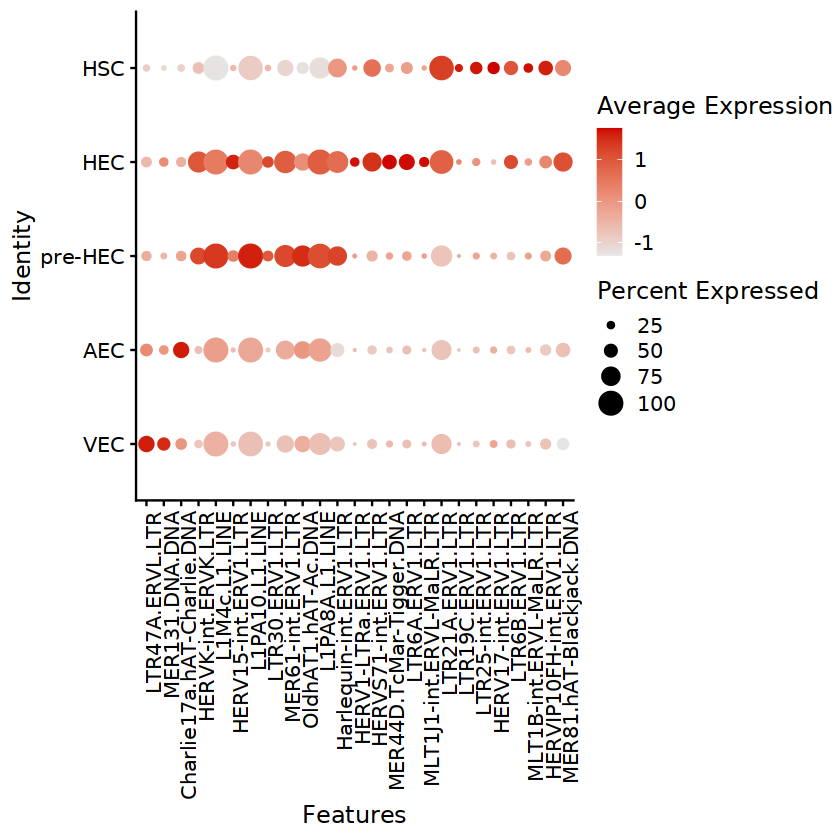

In [13]:
# top marker TE dotplot
marker_TE_significant <- subset(sample@misc$celltype_marker_TE, avg_log2FC >= 0.25 & p_val_adj <= 0.05)
marker_TE_significant <- marker_TE_significant[order(marker_TE_significant$cluster), ] %>% group_by(cluster) %>% top_n(9, avg_log2FC)
length(unique(marker_TE_significant$gene))
DotPlot(sample, features = unique(marker_TE_significant$gene), cols = c("grey90", "red3"), assay = "SCT", group.by = "celltype") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/featureplot_top_marker_TE_human.pdf", width = 10, height = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,pct.diff,p_val_adj_log,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<chr>
HERVS71-int.ERV1.LTR,7.873043e-09,0.8238551,0.735,0.339,1.656646e-04,HEC,HERVS71-int.ERV1.LTR,0.396,3.780770,LTR
HERVK-int.ERVK.LTR,7.819152e-50,1.3655715,0.628,0.265,1.645306e-45,pre-HEC,HERVK-int.ERVK.LTR,0.363,44.783753,LTR
MER44D.TcMar-Tigger.DNA,4.922001e-07,0.4491941,0.529,0.192,1.035688e-02,HEC,MER44D.TcMar-Tigger.DNA,0.337,1.984771,DNA
LTR6A.ERV1.LTR,1.897380e-06,0.5785922,0.588,0.279,3.992467e-02,HEC,LTR6A.ERV1.LTR,0.309,1.398759,LTR
LTR47A.ERVL.LTR,1.763385e-55,0.5976055,0.607,0.324,3.710514e-51,VEC,LTR47A.ERVL.LTR,0.283,50.430566,LTR
HERV15-int.ERV1.LTR,3.673452e-35,0.7737070,0.385,0.117,7.729677e-31,pre-HEC,HERV15-int.ERV1.LTR,0.268,30.111839,LTR


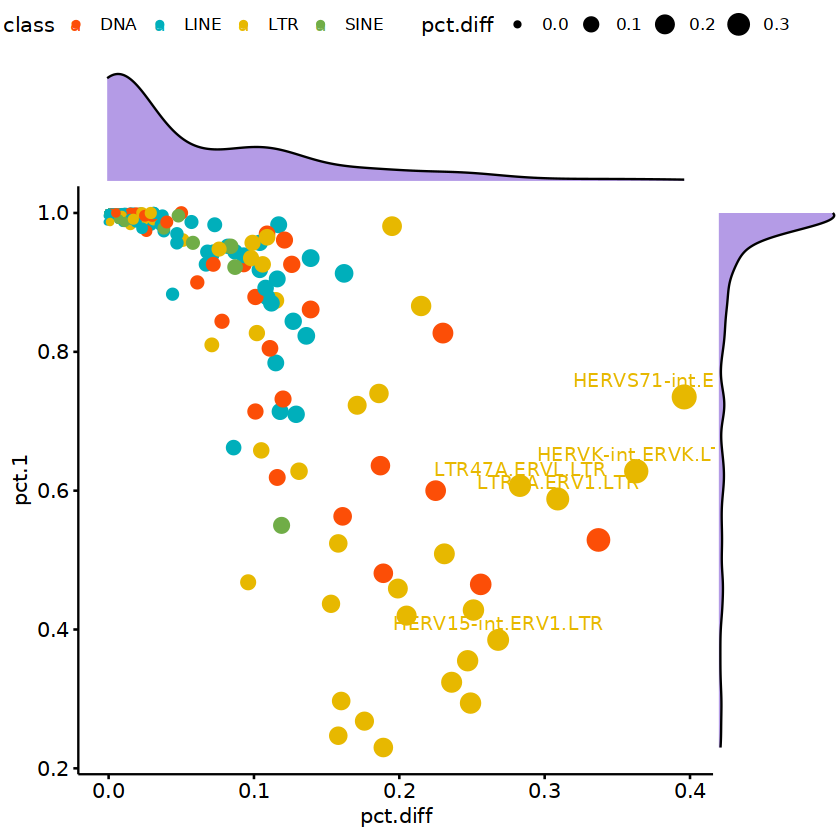

In [14]:
# marker specificity
marker_TE_significant <- subset(sample@misc$celltype_marker_TE, avg_log2FC >= 0.25 & p_val_adj <= 0.05)
marker_TE_significant <- marker_TE_significant[!duplicated(marker_TE_significant$gene), ]
marker_TE_significant$pct.diff <- marker_TE_significant$pct.1 - marker_TE_significant$pct.2
marker_TE_significant$p_val_adj_log <- -log10(marker_TE_significant$p_val_adj)
marker_TE_significant$class <- unlist(strsplit(marker_TE_significant$gene, split = ".", fixed = T))[seq(3, nrow(marker_TE_significant) * 3, by = 3)]
marker_TE_significant$class <- gsub(pattern = "Retroposon", replacement = "SINE", marker_TE_significant$class)
head(marker_TE_significant[order(marker_TE_significant$pct.diff, decreasing = T), ])
ggscatterhist(marker_TE_significant, x = "pct.diff", y = "pct.1", color = "class", size = "pct.diff", palette = c("#FC4E07", "#00AFBB", "#E7B800", "#70AD47"), label = "gene", label.select = c("HERV15-int.ERV1.LTR","HERVS71-int.ERV1.LTR","HERVK-int.ERVK.LTR","LTR6A.ERV1.LTR","LTR47A.ERVL.LTR"), margin.params = list(fill = "mediumpurple"))
ggsave("figure/marker_TE_specificity_human.pdf", width = 6, height = 6)

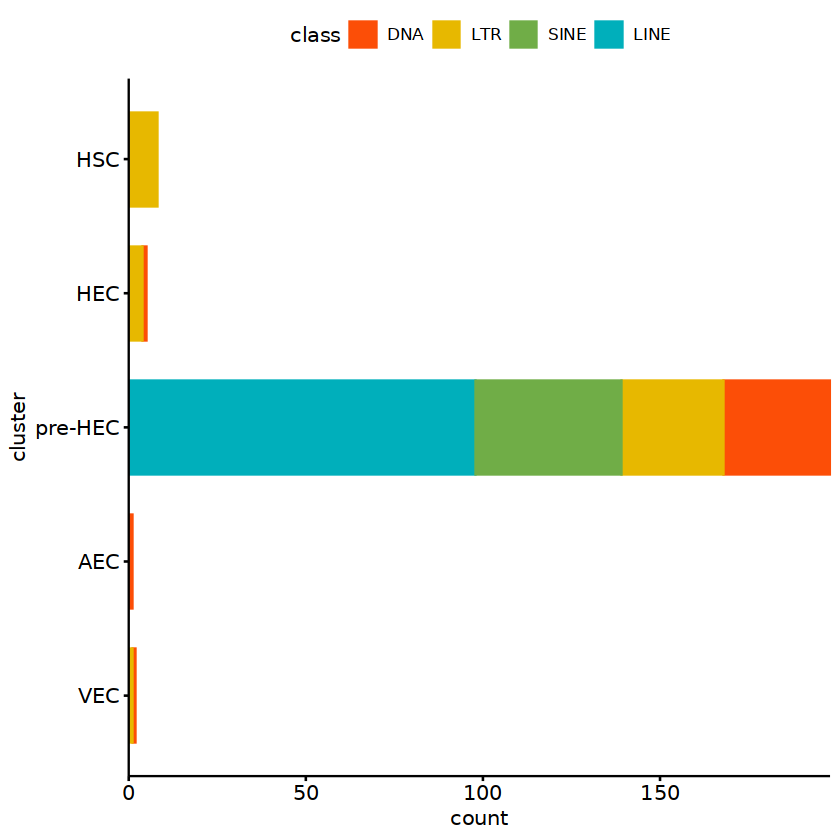

In [15]:
# plot marker TE class count
marker_TE_count <- data.frame(cluster = "0", class = "0", count = 0)
for(cluster in c("VEC","AEC","pre-HEC","HEC","HSC")){
    class_count <- as.data.frame(table(marker_TE_significant[marker_TE_significant$cluster == cluster, "class"]))
    class_count <- data.frame(cluster = cluster, class = class_count$Var1, count = class_count$Freq)
    marker_TE_count <- rbind(marker_TE_count, class_count)
}
marker_TE_count <- marker_TE_count[-1, ]

marker_TE_count$class <- factor(marker_TE_count$class, levels = rev(c("LINE","SINE","LTR","DNA")))
class_color <- rev(c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07"))
ggbarplot(marker_TE_count, x = "cluster", y = "count",
          fill = "class",               # change fill color by cyl
          color = "class",            # Set bar border colors to white
          palette = class_color,            # jco journal color palett. see ?ggpar
          sort.val = "none",           # Sort the value in dscending order
          orientation = "horiz"
          ) + scale_y_continuous(expand = c(0, 0))
ggsave("figure/marker_TE_class_count_human.pdf", width = 3, height = 4)

In [16]:
# plot selected TE markers
TE_marker_selected <- c("LTR47A.ERVL.LTR","HERVK-int.ERVK.LTR","HERV15-int.ERV1.LTR","HERVS71-int.ERV1.LTR")
for(gene in TE_marker_selected){
    FeaturePlot(sample, features=gene, cols=c("grey90","red3"), reduction="umap", keep.scale = "all")
    ggsave(paste("figure/EHT_TE", gene, "human.pdf", sep = "_"), width = 5, height = 5)
}

In [17]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] gtools_3.9.4       reshape2_1.4.4     ggrepel_0.9.3      RColorBrewer_1.1-3
 [5] Hmisc_5.0-1        Matrix_1.5-4       dplyr_1.1.1        ggpubr_0.6.0      
 [9] ggplot2_3.4.2      harmony_0.1.1      Rcpp_1.0.10        SeuratObject_4.1.3
[13] Seurat_4.3.0      

loaded via a namespace (and not attached):
  [1] uuid_1.1-0                  backports_1.4.1            
  [3] systemfonts_1.0.4           plyr_1.8.8